# EQUITY AMERICAN OPTION - QL COMPARISON

Valuation and Risk of American-style options on equity compared with example at
http://gouthamanbalaraman.com/blog/american-option-pricing-quantlib-python.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from financepy.utils import *
from financepy.market.curves.discount_curve_flat import *
from financepy.products.equity import *
from financepy.models.black_scholes import *

####################################################################
#  FINANCEPY BETA Version 0.350 - This build: 30 Apr 2024 at 21:20 #
#     This software is distributed FREE AND WITHOUT ANY WARRANTY   #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



# Define the Call and Put Options

In [3]:
value_dt = Date(8, 5, 2015)

In [4]:
expiry_dt = Date(15, 1, 2016)

In [5]:
strike_price = 130

Create the call Option

In [6]:
amCallOption = EquityAmericanOption(expiry_dt, strike_price, OptionTypes.AMERICAN_CALL)

In [7]:
print(amCallOption)

OBJECT TYPE: EquityAmericanOption
EXPIRY DATE: 15-JAN-2016
STRIKE PRICE: 130
OPTION TYPE: OptionTypes.AMERICAN_CALL
NUMBER: 1.0


We can also define an American option with a European payoff - this way we will use the same CRR tree for the pricing.

In [8]:
euCallOption = EquityAmericanOption(expiry_dt, strike_price, OptionTypes.EUROPEAN_CALL)

In [9]:
print(euCallOption)

OBJECT TYPE: EquityAmericanOption
EXPIRY DATE: 15-JAN-2016
STRIKE PRICE: 130
OPTION TYPE: OptionTypes.EUROPEAN_CALL
NUMBER: 1.0


We can also define an actual vanilla call option which will be priced using Black Scholes.

In [10]:
call_option = EquityVanillaOption(expiry_dt, strike_price, OptionTypes.EUROPEAN_CALL)

In [11]:
print(call_option)

OBJECT TYPE: EquityVanillaOption
EXPIRY DATE: 15-JAN-2016
STRIKE PRICE: 130
OPTION TYPE VALUE: OptionTypes.EUROPEAN_CALL
NUMBER: 1.0


Now we can explore the pricing of all three to check for consistency and tree convergence.

## Valuation

In [12]:
stock_price = 127.62
volatility = 0.20
interest_rate = 0.001
dividend_yield = 0.0163

In [13]:
discount_curve = DiscountCurveFlat(value_dt, interest_rate,
                                     FrequencyTypes.CONTINUOUS, DayCountTypes.ACT_365F)

In [14]:
dividend_curve = DiscountCurveFlat(value_dt, dividend_yield)

We now define the model. This is Black-Scholes. We can also specify the number of steps to use on the tree,

In [15]:
num_steps_per_year = 400

In [16]:
model = BlackScholes(volatility, BlackScholesTypes.DEFAULT, num_steps_per_year)

In [17]:
amCallOption.value(value_dt, stock_price, discount_curve, dividend_curve, model)

6.8391380697921615

Compare it to European using same tree

In [18]:
euCallOption.value(value_dt, stock_price, discount_curve, dividend_curve, model)

6.751136062156512

This is lower as we would expect due to the lack of early exercise. Let's check this against the Black Scholes model analytical form.

In [19]:
call_option.value(value_dt, stock_price, discount_curve, dividend_curve, model)

6.74935662387659

The price is close to the 6.74927 found by QL - see http://gouthamanbalaraman.com/blog/european-option-binomial-tree-quantlib-python.html. Differences with QL could be due to differences in time calculations. It is also different from the Tree value but that is a tree convergence issue. Let's see how good convergence is.

## Tree Convergence

In [20]:
num_steps_per_year = range(5, 200, 1)

In [21]:
amTreeValue = []
euTreeValue = []
euAnalValue = []
volatility = 0.20

for num_steps in num_steps_per_year:
    model = BlackScholes(volatility, BlackScholesTypes.DEFAULT, num_steps)
    v_am = amCallOption.value(value_dt, stock_price, discount_curve, dividend_curve, model)
    v_eu = euCallOption.value(value_dt, stock_price, discount_curve, dividend_curve, model)
    v_bs = call_option.value(value_dt, stock_price, discount_curve, dividend_curve, model)
    
    amTreeValue.append(v_am)
    euTreeValue.append(v_eu)
    euAnalValue.append(v_bs)

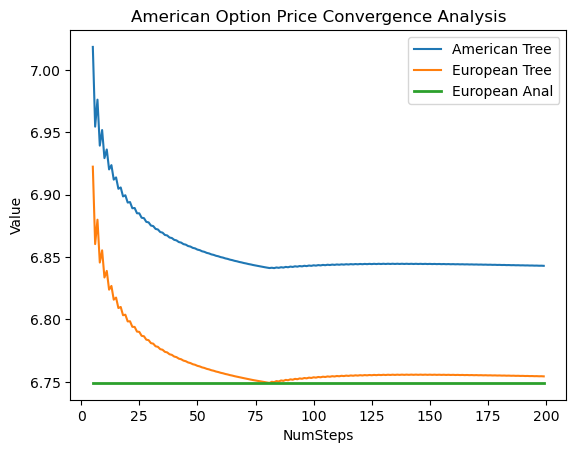

In [22]:
plt.title("American Option Price Convergence Analysis")
plt.plot(num_steps_per_year, amTreeValue, label="American Tree")
plt.plot(num_steps_per_year, euTreeValue, label="European Tree")
plt.plot(num_steps_per_year, euAnalValue, label="European Anal", lw =2)
plt.xlabel("NumSteps")
plt.ylabel("Value")
plt.legend();

Agreement with QL is very good and tree convergence appears much better - probably assisted by fact that I average even and odd numbers of steps internally.

Copyright (c) 2020 Dominic O'Kane